<h1 style="text-align: center;"> Dow Jones Indicators </p>

##### NOTE: Plots are Dow Data, comments & insights are copied from Google Mobility

## Table of contents
1. [Problem Domain](#Problem-Domain)
2. [Required Libraries](#Required-Libraries)
3. [Google Mobility Data](#Google-Mobililty-Data)
4. [Data Exploration](#Data-Exploration)
5. [Visualizations](#Visualizations)
6. [Resampling](#Resampling)<br>
7. [Decomposition](#Decomposition)
8. [Time Series Stationarity](#Time-Series-Stationarity)
9. [Making Time Series Stationary](#Making-Time-Series-Stationary)
10. [Autocorrelations and Partial Autocorrelations](#Autocorrelations-and-Partial-Autocorrelations)
11. [ARIMA Modeling](#ARIMA-Modeling)
12. [Conclusion](#Conclusion)

## Problem Domain

[[ go back to the top ]](#Table-of-contents)

In this notebook, time-series processing methods are applied for forecasting oil stock performance as part of the requirements of the RMDS 2021 Data Science Competition. Here, the *Google COVID-19 Community Mobility Reports* are leveraged to generate insights with time series modeling. We have just over one year of daily mobility data, measured as the percent change from established baseline values.

Google has provided access to this anonymized data in support of public health efforts to combat COVID-19. There is no historical connection of this data with oil stock performance and thus there are no currently established metrics driving performance decisions. Identifying trends in mobility and the impact of unique indicators will help our team make better decisions on how to interpret a year highly disrupted by an air-born pandemic.

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python libraries such as:

In [11]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Time-Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy import signal
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

<a id='Dow-Jones-Data'></a>

## Dow Jones Data

[[ go back to the top ]](#Table-of-contents)

This dataset contains just over a year's worth of daily-frequency data from six sub-categories ("Indicators") in the United States. A total of 382 records, aggregated across county and state levels, were collected from 2020-02-15 to 2021-03-02 (YYYY-MM-DD). Each mobility indicator is measured as percent change from baseline.

From the official documentation website ([source](https://www.google.com/covid19/mobility/data_documentation.html?hl=en)):

Baseline

*    The median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

**Place Categories**

|Indicator|Data Type|Dataset|Region-Frequency|Description|
|---|---|---|---|---|
|**Grocery & Pharmacy**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.|
|**Parks**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.|
|**Transit Stations**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like public transport hubs such as subway, bus, and train stations.|
|**Retail & Recreation**|*float*|Google Mobility|U.S. Daily|Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.|
|**Residential**|*float*|Google Mobility|U.S. Daily|Mobility trends for places of residence.|
|**Workplaces**|*float*|Google Mobility|U.S. Daily|Mobility trends for places of work.|

#### Load Data

In [12]:
# Load Data Function
def LOAD_DATA(filepath, filename):
    # Read CSV files
    if filename.endswith('.csv'):
        new_df = pd.read_csv(filepath+filename)

    # Read Excel files
    elif filename.endswith('.xlsx'):
        new_df = pd.read_excel(filepath+filename)
    print(type(new_df.index))
    if type(new_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        for col in new_df.columns:
            if col.lower().find('date') != -1:
                print(f"TIMESTAMP FOUND! '{col}'")
                print()
                new_df['date'] = pd.to_datetime(new_df[col]) # format = '%Y/%m/%d'
#                new_df.set_index('date', inplace = True)
                # If datetime col was already == 'date', no need to drop col after set_index, otherwise...
                if col != 'date':
                    new_df.drop(columns = col, inplace = True)
                
    # Try to identify the date column
    elif type(new_df.index) == pd.core.indexes.datetimes.DatetimeIndex:
        print('Index already in datetime')
        
    display(new_df.info())
    return new_df

In [13]:
filepath = '../../data/Financial_Market/'
filename = 'FRED_stock_market_indicators&index.xlsx'
df = LOAD_DATA(filepath, filename)

<class 'pandas.core.indexes.range.RangeIndex'>
TIMESTAMP FOUND! 'Date'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Value                5000 non-null   float64       
 1   Sub-Sector           5000 non-null   object        
 2   Super Region         5000 non-null   object        
 3   Description          5000 non-null   object        
 4   Time Level           5000 non-null   object        
 5   Category 2           5000 non-null   object        
 6   Seasonal Adjustment  5000 non-null   object        
 7   Unit                 5000 non-null   object        
 8   Source               5000 non-null   object        
 9   date                 5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 390.8+ KB


None

In [14]:
def drop_columns(dataframe):
    redund_dict = {}
    df = dataframe
    # Drop redundant columns and store redundant data more efficiently
    for col in df:
        # Identify columns with only one value repeated on every row
        value_counts = df[col].value_counts().count()
        # Reduce DataFrame if any columns contain only one value
        if value_counts == 1:
            k = col # keys
            v = df[col].value_counts().index[0] # values
            # Store redundant data in a dictionary
            redund_dict.update({k : v})
            # Drop redundant data columns
            df.drop(columns=[col], inplace = True)
    return df
drop_columns(df)

,Value,Description,date
0,843.23,DOW JONES UTILITY AVERAGE,2020-08-07
1,664.80,DOW JONES UTILITY AVERAGE,2018-03-07
2,872.17,DOW JONES UTILITY AVERAGE,2021-01-25
3,828.87,DOW JONES UTILITY AVERAGE,2020-08-06
4,669.68,DOW JONES UTILITY AVERAGE,2018-03-06
...,...,...,...
4995,10485.02,DOW JONES TRANSPORTATION AVERAGE,2019-07-05
4996,10416.13,DOW JONES TRANSPORTATION AVERAGE,2019-07-08
4997,10741.50,DOW JONES TRANSPORTATION AVERAGE,2018-07-20
4998,10339.01,DOW JONES TRANSPORTATION AVERAGE,2019-07-09


#### Add Calculated Columns

Some important metrics can be calculated and included in the modeling.

In [15]:
#df['new_column'] = df.column1 - df.column2
#df.head()

## Data Exploration

[[ go back to the top ]](#Table-of-contents)

In [16]:
df.describe()

,Value
count,5000.000000
mean,9613.526282
std,8795.180847
min,610.890000
25%,2650.387500
50%,8394.125000
75%,10919.055000
max,31961.860000


In [17]:
df.groupby('Description').describe()

Value                                      \
                                   count         mean          std       min   
Description                                                                    
DOW JONES COMPOSITE AVERAGE       1000.0   8503.29972   781.648210   6100.31   
DOW JONES INDUSTRIAL AVERAGE      1000.0  25528.27736  2550.523811  18591.93   
DOW JONES TRANSPORTATION AVERAGE  1000.0  10360.31721  1095.279193   6703.63   
DOW JONES UTILITY AVERAGE         1000.0    774.83137    69.059220    610.89   
S&P 500                           1000.0   2900.90575   367.663080   2237.40   

                                                                               
                                         25%        50%         75%       max  
Description                                                                    
DOW JONES COMPOSITE AVERAGE        7998.0225   8484.045   8957.9100  10547.40  
DOW JONES INDUSTRIAL AVERAGE      24101.2900  25581.570  27002.9450  31961.86  
DOW JONES TRANSPORTATION AVERAGE   9673.5350  10430.840  10919.0550  13630.55  
DOW JONES UTILITY AVERAGE           720.8650    758.925    830.4600    960.89  
S&P 500                            2650.3875   2833.840   3098.3775   3934.83

In [18]:
dow_indicators = list(df.Description.value_counts().index)
count = 0
for indicator in dow_indicators:
    # Trim redundant substrings with last_char
    last_char = len(indicator)
    # Remove casing and extra white space
    formated_name = indicator[:last_char].strip().lower()
    # Temporary DataFrame 'df_i' of just one indicator (DJCA, DJIA, DJTA, DJUA, etc.)
    df_i = df[df['Description']==indicator].copy()
    #df_i['date'] = df_i['Date Value']
    df_i = df_i.groupby(['date'], as_index=True).mean()
    # Replace default 'Value' with descriptive col name
    df_i.rename(columns = {'Value': formated_name.replace(" ", "_")}, inplace = True)
    if count == 0:
        df_0 = df_i.copy()
    else:
        df_0 = pd.concat([df_0, df_i], axis =1)
    count += 1
display(round(df_0, 2))

,dow_jones_transportation_average,dow_jones_utility_average,dow_jones_industrial_average,s&p_500,dow_jones_composite_average
date,,,,,
2017-03-24,8928.78,705.95,20596.72,2343.98,7116.60
2017-03-27,8935.11,702.45,20550.98,2341.59,7103.24
2017-03-28,9096.83,703.36,20701.50,2358.57,7169.15
2017-03-29,9075.39,699.88,20659.32,2361.13,7150.48
2017-03-30,9151.60,695.07,20728.49,2368.06,7172.40
...,...,...,...,...,...
2021-02-22,13381.42,830.38,31521.69,3876.50,10416.13
2021-02-23,13403.11,835.85,31537.35,3881.37,10432.98
2021-02-24,13630.55,825.65,31961.86,3925.43,10547.40


> *Observations*
>
> Notice: We do not have to deal with missing values. However, all mobility indicators seems to have tailed off extreme values. 

## Visualizations

[[ go back to the top ]](#Table-of-contents)

In [19]:
plt.rcParams["figure.figsize"] = (20,20)
plt.style.use('seaborn')

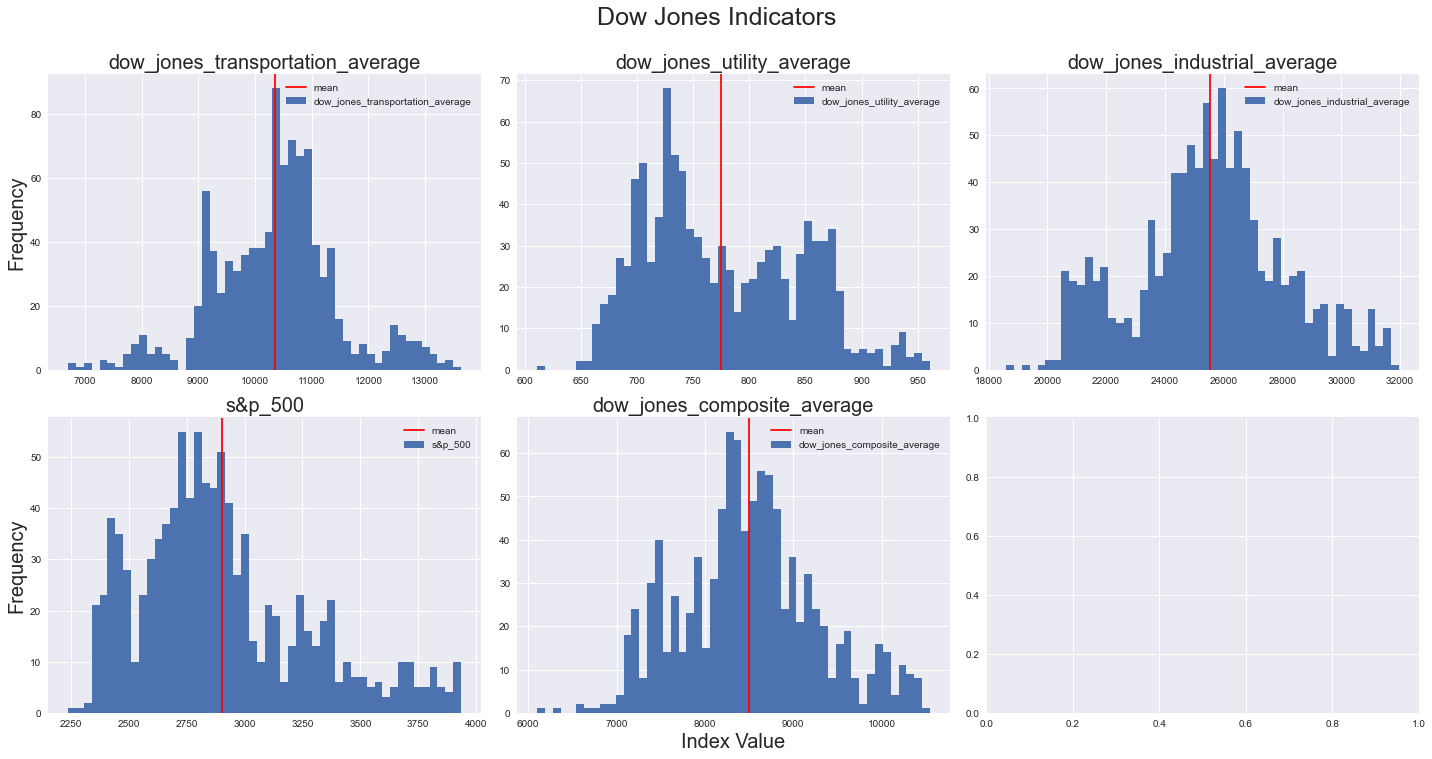

In [20]:
df = df_0.copy()
nrows, ncols, nbins = 2, 3, 50

fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        # To manage an odd number of subplots
        if (row == nrows-1) & (col == ncols-1):
            break
        series = df[col_list[count]]
        ax[row][col].hist(series, bins = nbins, label=series.name)
        ax[row][col].set_title(col_list[count], fontsize = label_size)
        ax[row][col].axvline(x=series.mean(), color= 'r', label = 'mean')
        ax[row][col].legend()
        count+=1
    ax[row][0].set_ylabel('Frequency', fontsize = label_size)   
ax[1][1].set_xlabel('Index Value', fontsize = label_size)
plt.suptitle('Dow Jones Indicators', y = 1.05, fontsize = label_size+5)
plt.tight_layout()

> *Observations*
>
> By plotting the histogram of mobility, we can see the characteristic distribution of each indicator.
> - Mobility trends around workplaces are predominantly negative indicating lower mobility relaitive to the baseline, and seem to center around minus 20%. There are also scattered values between -80 to -40 percent-change that require further cleaning/investigation for interpretation.
> - Mobility around places of retail, restaurants, and recreation contain many extreme low values which may pose problems in downstream analysis. 
> - Mobility trends around parks and places of residence seem to be mostly positive with two overlapping peaks in parks. 
> - Mobility around markets and drug stores seem to be centered around 0% change (in contrast to all other indicators), however, both ends seems to have scattered extreme values that may require further investigation.

### Look at a Zoomed-In Window

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2017-03-24 to 2021-02-26
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   dow_jones_transportation_average  1000 non-null   float64
 1   dow_jones_utility_average         1000 non-null   float64
 2   dow_jones_industrial_average      1000 non-null   float64
 3   s&p_500                           1000 non-null   float64
 4   dow_jones_composite_average       1000 non-null   float64
dtypes: float64(5)
memory usage: 46.9 KB


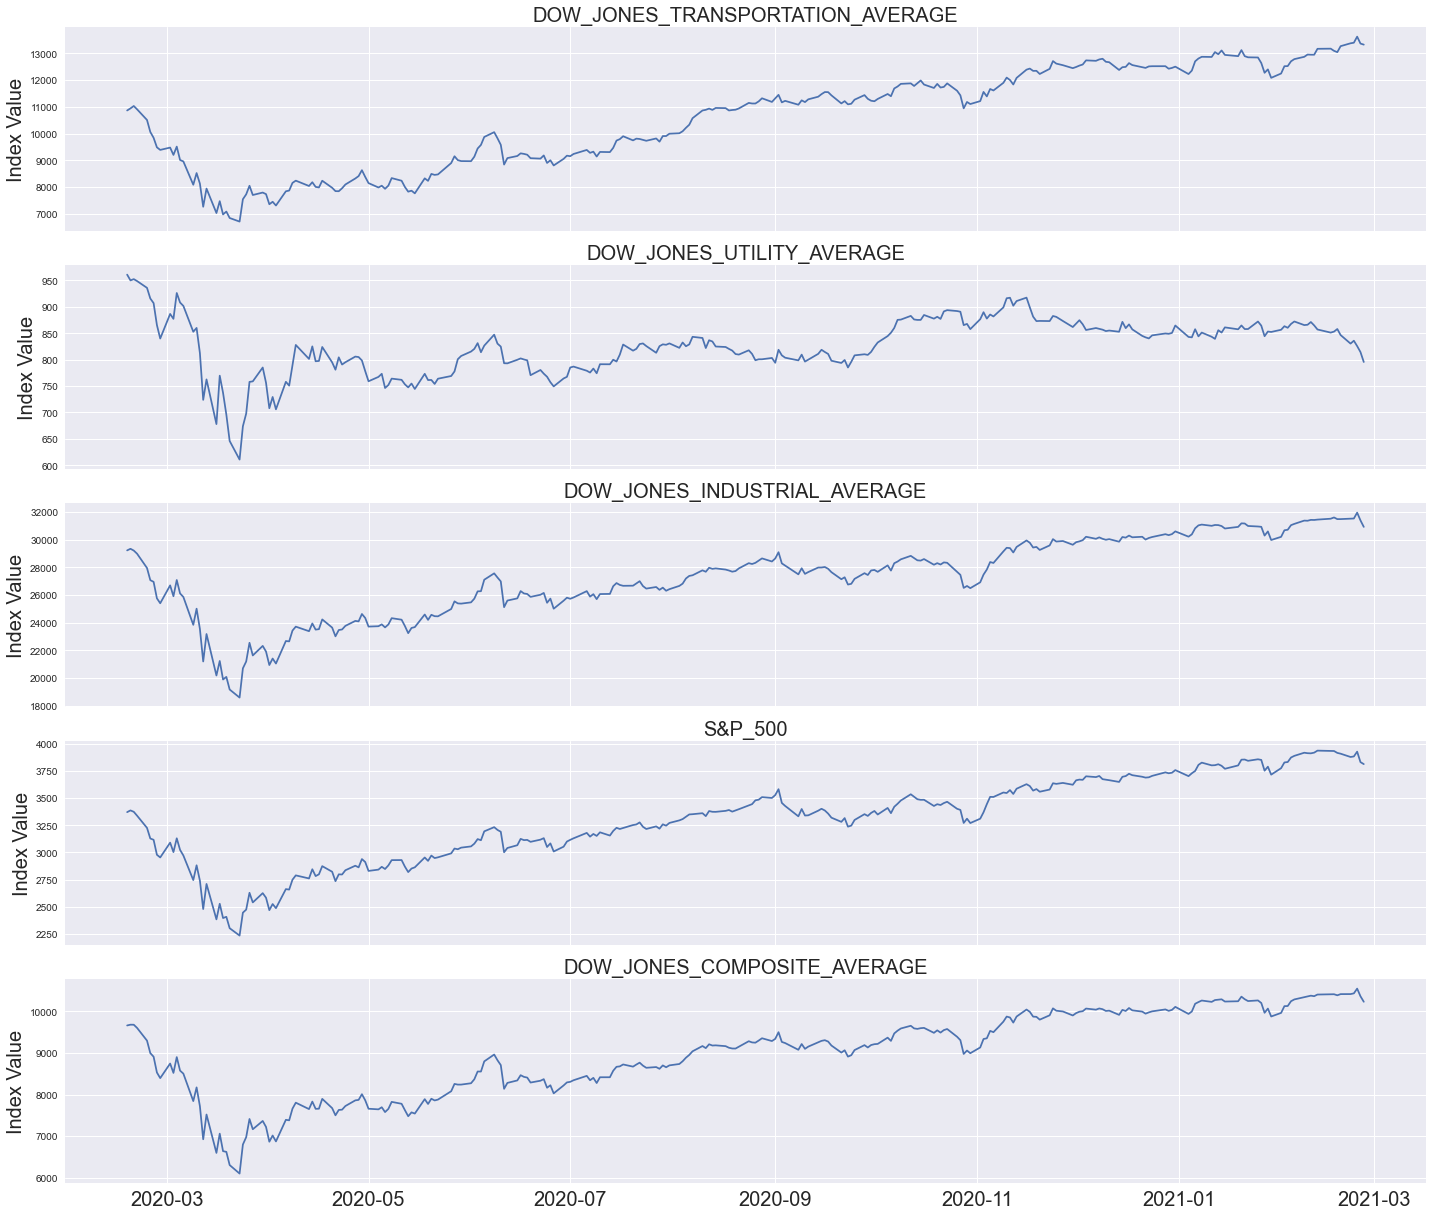

In [22]:
nrows, ncols = 5, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(20,17), squeeze=False, sharex=True)

# Choose range of interest
start = '2020-02-15'
end = '2021-02-26'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)

plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
> 
> When zoomed into the "holiday season", we can see the relationship between the mobility trends more clearly. The peaks in residential data show the private celebrations held by Americans around Thanksgiving, Christmas, and the New Year. These are the %-changes compared to a non-holiday baseline so it is expected that all other indicators would display a downward spiking mobility trend. Distinct cyclic behavior in workplace mobility is evident weekly, and appears to correspond with dips in residential mobility. This could be an indication of data-seasonality which will hinder series stationarity if left untreated.

### Look at the Entire Data

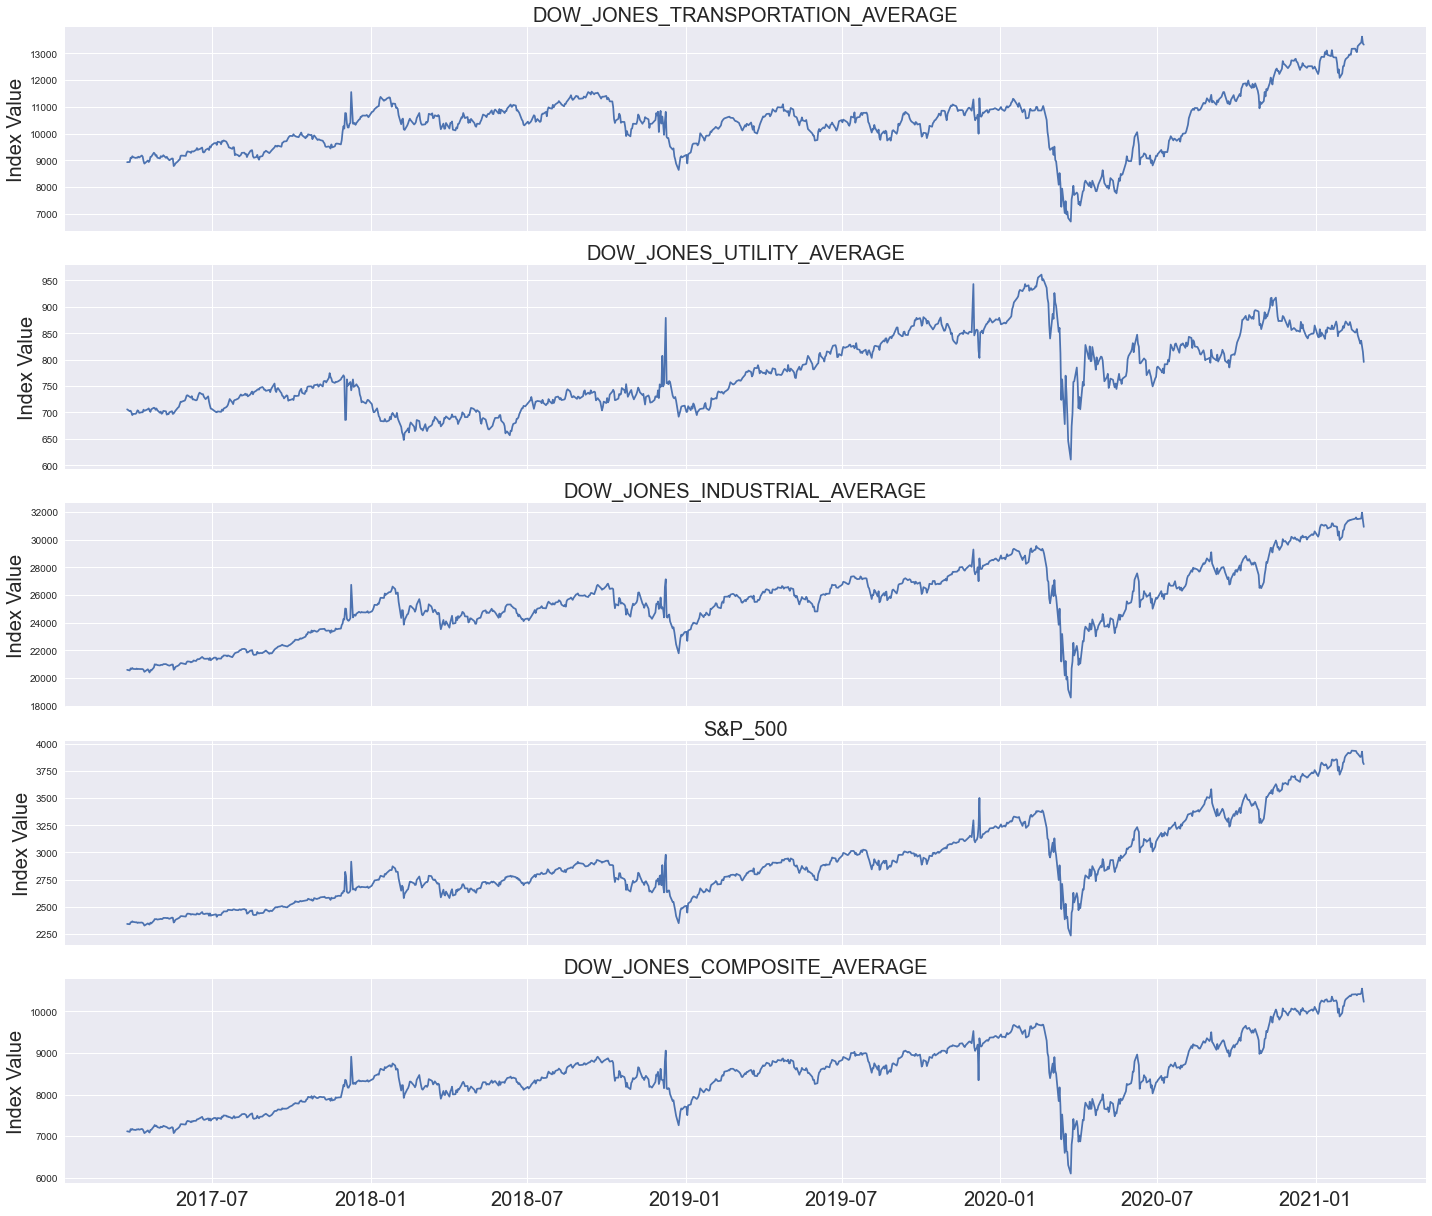

In [23]:
#nrows, ncols = 5, 1
fig, ax = plt.subplots(nrows = 5,
                       ncols = 1,
                       figsize=(20,17), 
                       squeeze=False, # Make it all fit
                       sharex=True, # Make toggle switch
                       sharey=False) # Make User Input and toggle

# Choose range of interest
start = '2017-03-24'
end = '2021-02-26'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)

plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
>
> A full year's worth of daily data is too condensed. Although some significant impacts such as national holidays and government enforced shutdowns can be identified, it's quite difficult to obtain actionable insights from the entire dataset. Big-picture insights can be extracted from subtle variations in the data after further processing.


## Resampling

[[ go back to the top ]](#Table-of-contents)

In [24]:
def resample_rolling(data = df, d = 7, f = 'W'):
    # Figsize probably needs to be generalized to remove hardcoded dimensions
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 1,
                            sharex= True,
                            sharey=True,
                            figsize=(14,8))
    days = d
    freq = f
    df_0 = data
    
    # Resample
    df_m = df_0.resample(freq).mean()
    # Rolling mean: Mean of a moving window across time periods, smoothing
    df_rm = df_0.rolling(days).mean()
    
    #sns.lineplot(data = df_0, ax = axs[0]);
    sns.lineplot(data = df_m, ax = axs[0], legend = False);
    
    #sns.lineplot(data = df_0, ax = axs[1]);
    sns.lineplot(data= df_rm, ax = axs[1], legend = 'full');
    
    plt.suptitle('Indicator Index Value', fontsize = label_size)
    #axs[0].xticks(fontsize =label_size), plt.yticks(fontsize =label_size)
    #axs[0].get_legend().remove()
    axs[1].legend(fontsize = 13,
                  #loc='best',
                  bbox_to_anchor=(0.5, 0.6, 0.5, 0.1)) # (x, y, width, height)
    plt.tight_layout()
    return

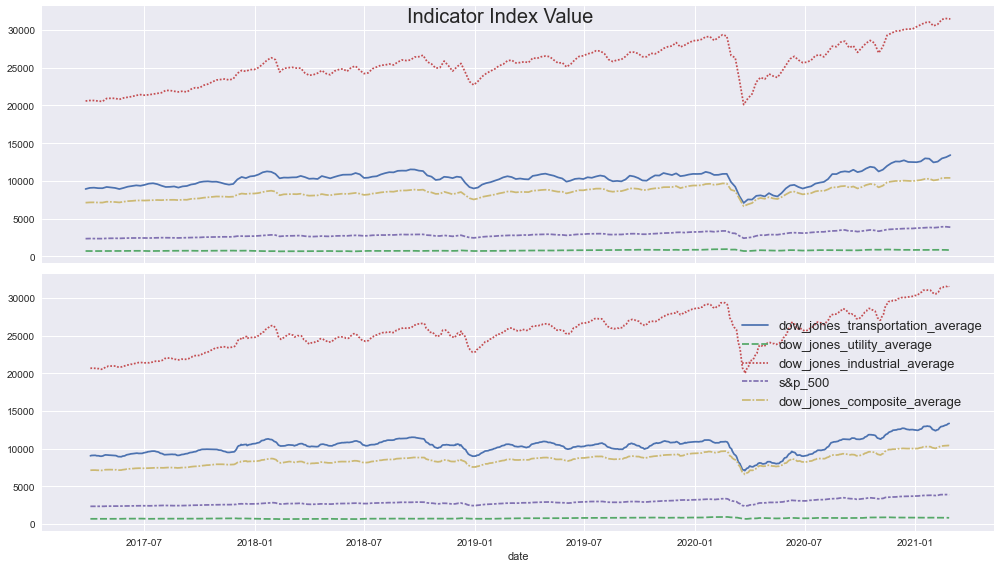

In [25]:
# Default is 7-days (one week = 'W')
resample_rolling()

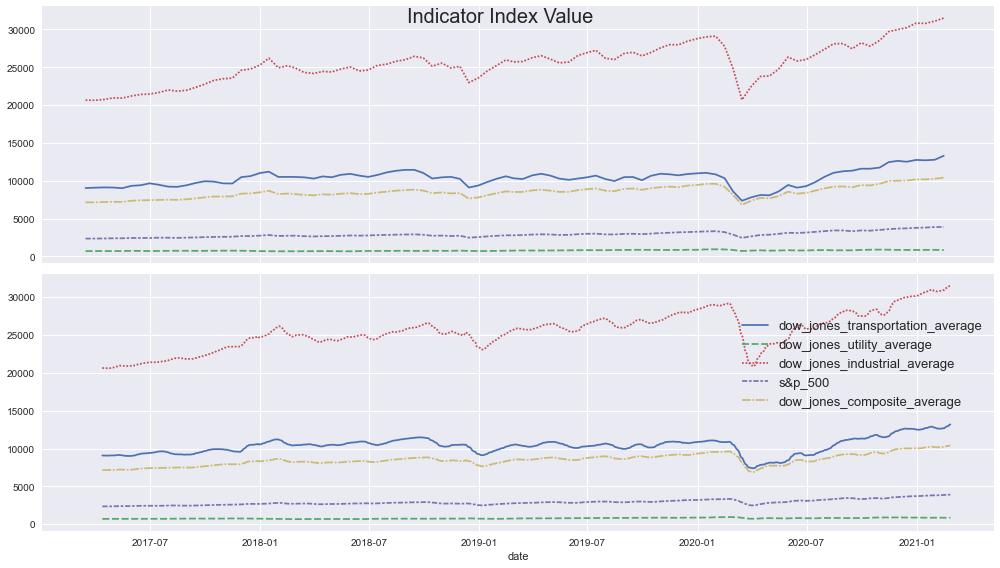

In [26]:
resample_rolling(d=14, f='SM')

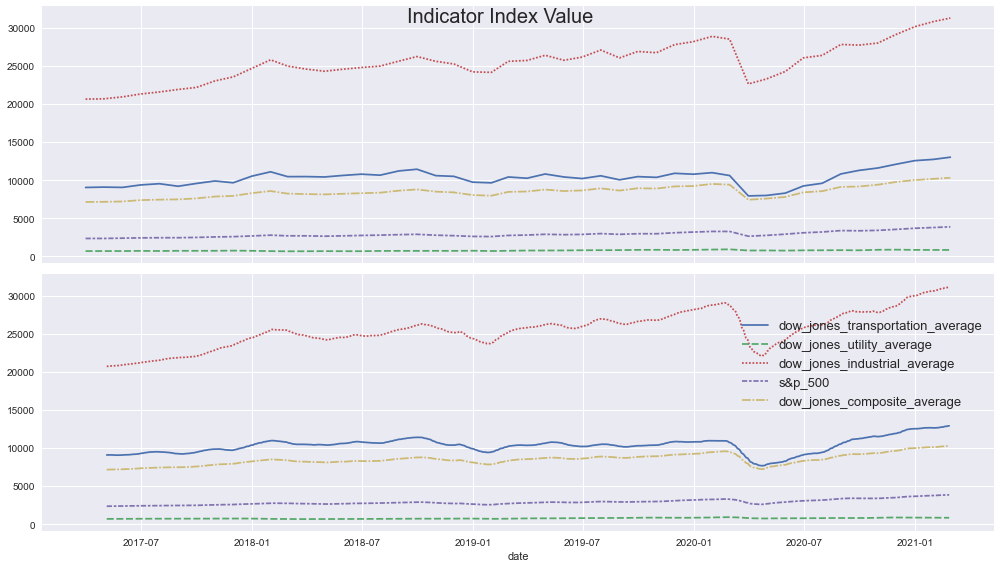

In [27]:
resample_rolling(d=30, f='M');

> *Observations*
>
> We can clearly see a downward trend in parks mobility when the winter months bring less favorable outdoor weather. Currently, it can be seen that all mobility indicators are converging together slightly lower than this time last year except, notably, residential mobility trends remain steadily around 10% higher. This visualization allows us to quickly identify intervals for close inspection, aiding in an abnormality analysis.
>
> **The rest of the analysis, will focus on working with the resampled mobility data**

In [28]:
#resample_rolling(d=90, f='Q')
#resample_rolling(d=180, f='BA')
#resample_rolling(d=365, f='Y')
freq = 'W'
df_r = df.resample(freq).mean()

The data will be subset up until 2020-08-08 where the mobility was relative stable for model building and analysis. The latter part of the data shows sharp spikes that may be result of government shutdowns, holidays, etc. which might not suitable for time-series modeling.

## Decomposition

[[ go back to the top ]](#Table-of-contents)

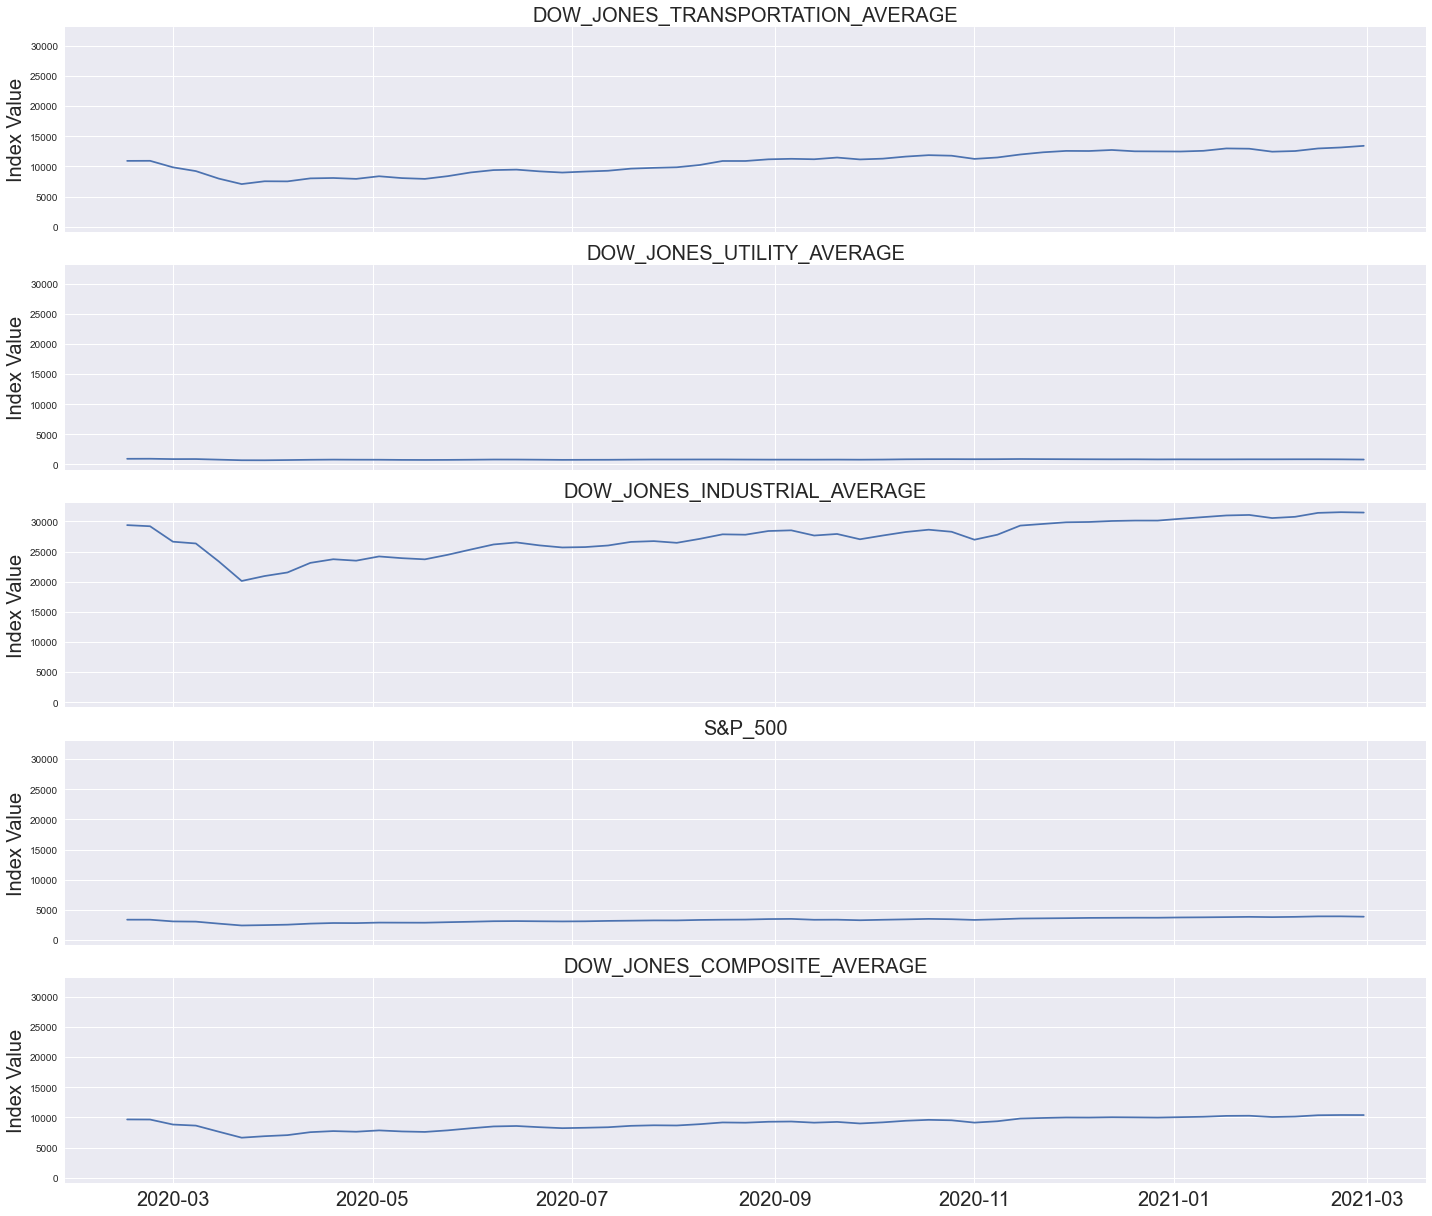

In [29]:
fig, ax = plt.subplots(nrows = 5,
                       ncols = 1,
                       figsize=(20,17),
                       squeeze=False,
                       sharey = True,
                       sharex=True)

# Choose time-series subset(date range of interest)
start = '2020-02-15' # '2020-02-15' first date
end = '2021-03-02'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df_r.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)
plt.xticks(fontsize =label_size)
plt.tight_layout()

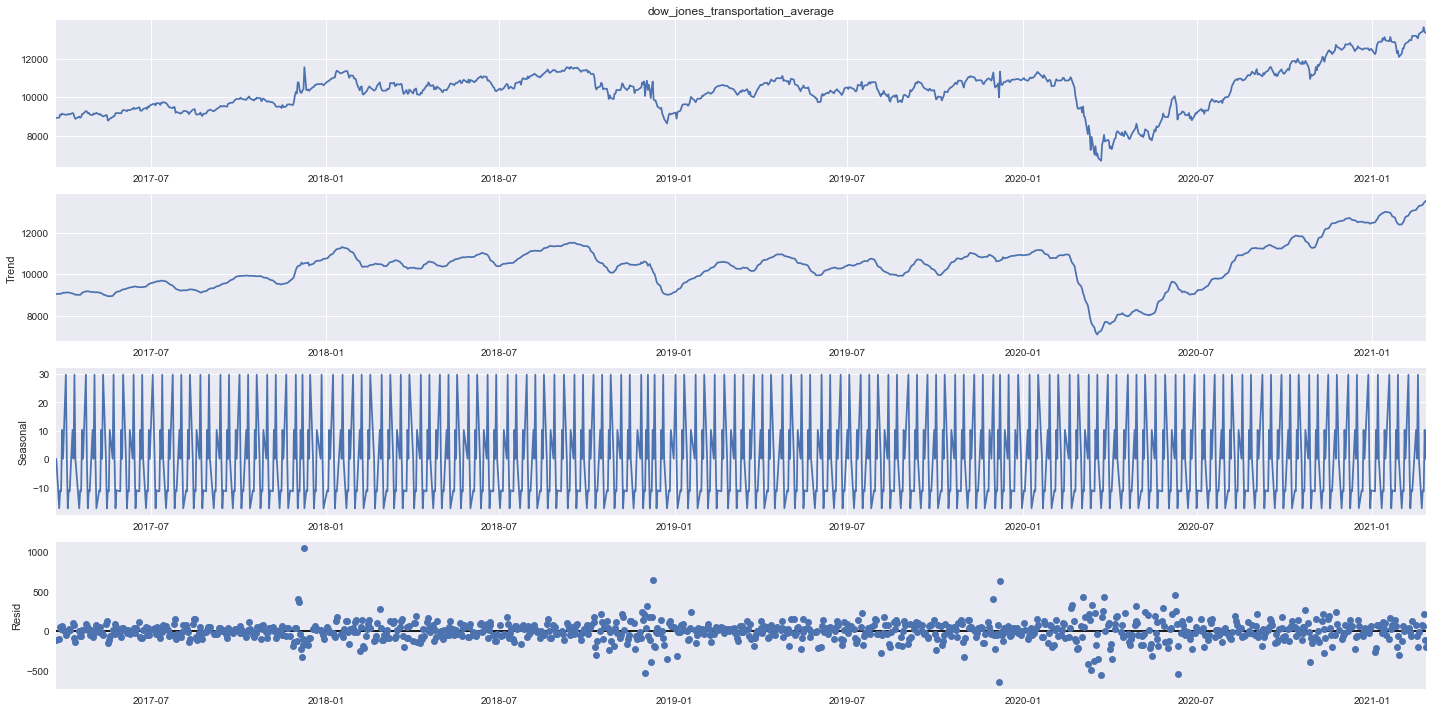

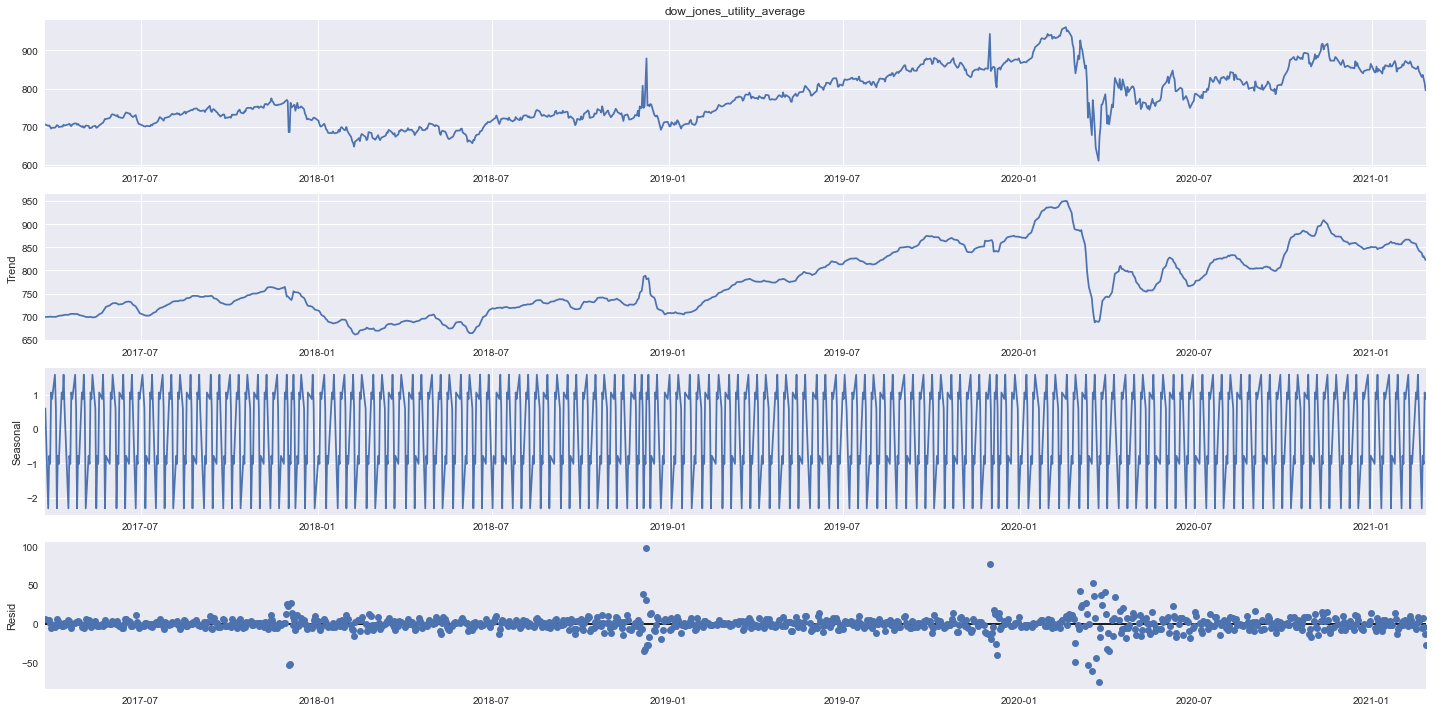

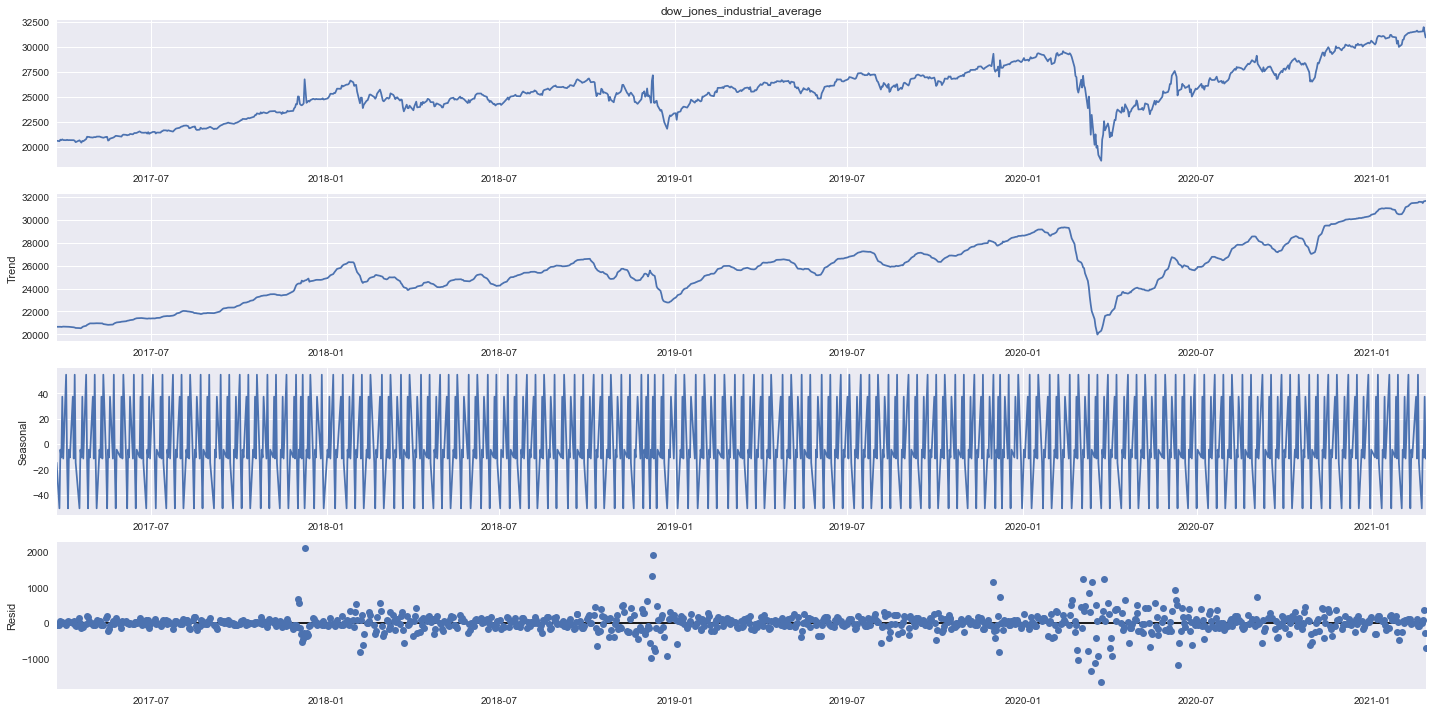

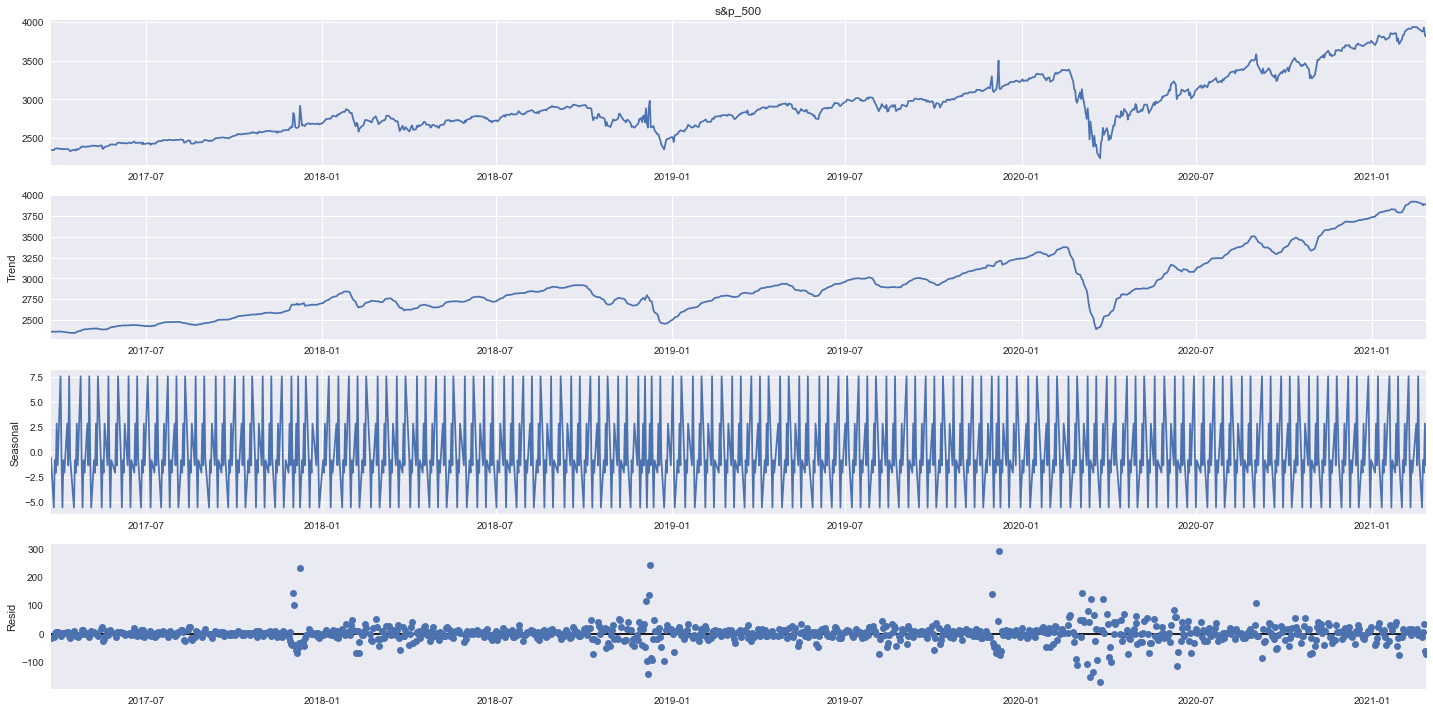

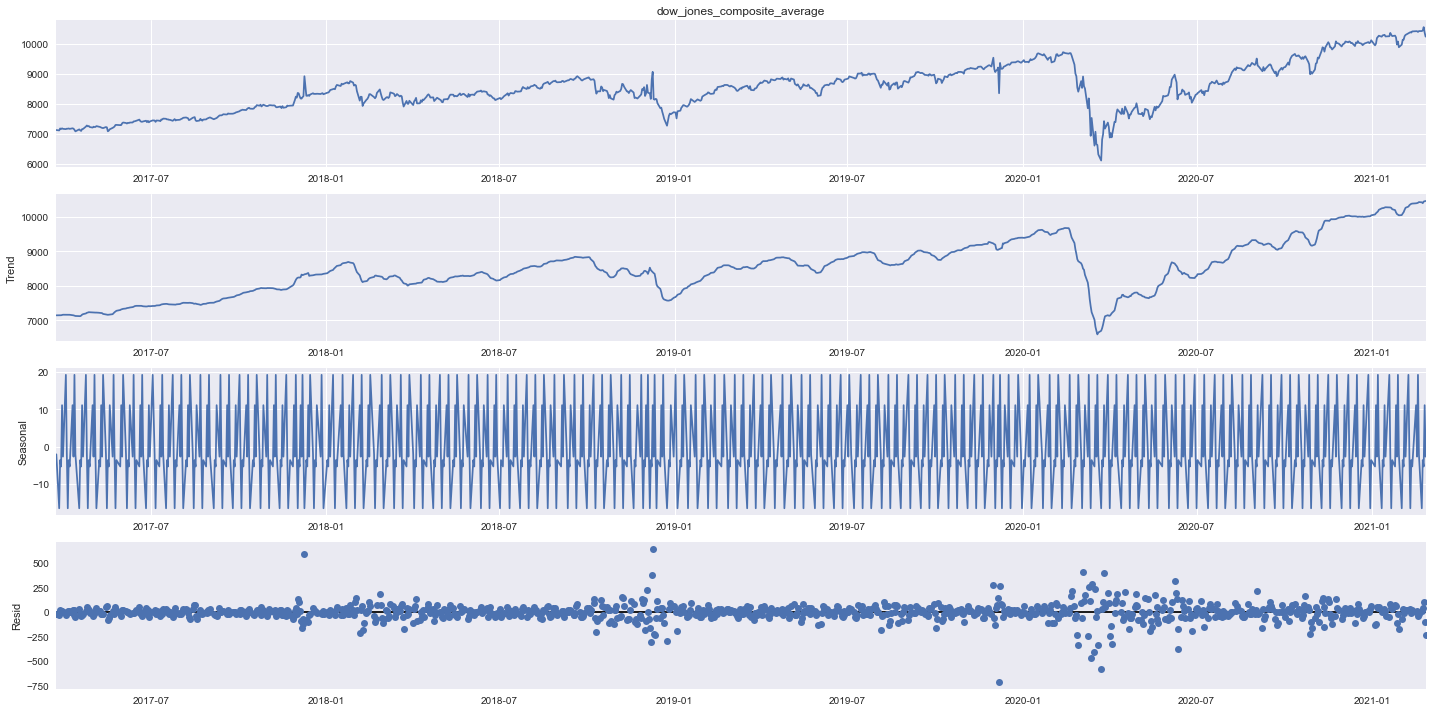

In [30]:
# Decompose time-series into Trend, Seasonality and Residuals
col_list = list(df.columns)

# Choose range of interest
start = '2017-03-24'
end = '2021-02-26'

for col_i in range(len(df.columns)):
    series = df.loc[start:end, col_list[col_i]]
    decomposed = sm.tsa.seasonal_decompose(series, model = 'additive', period=7, extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three time-series components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    # residuals = [ Observed - (trend + seasonality) ]
    residual = decomposed.resid

> *Observations*
>
> With the data decomposed, mobility trends are noticeably short lived. A consistent downward trend is evident, for all indicators other than the increasing-residential and the steady-workplace indicators, from October 2020 through January 2021 (most recent 4 months). The seasonal aspect of the data may or may not be statistically significant, but a more conservative approach handling suggested seasonality may be apropriate. In particular, the Workplaces and Residential Mobilities may benefit from seasonal adjustment with differencing

## Time Series Stationarity


[[ go back to the top ]](#Table-of-contents)

__Check if the time series is stationarity or not:__

1. __Rolling Statistics__: Plot the moving average & moving variance, check if either vary in time.

2. __Augmented Dickey-Fuller Test:__ A statistical test for checking stationarity.
  - Null Hypothesis (H0): the time-series is NON-stationary. <br>
  - Alternate Hypothesis (H1): Reject H0, the time-series is STATIONARY.
> p-value >  threshold: FAIL to reject H0, data is NON-stationary. <br>
> p-value<= threshold: Reject H0, the data is STATIONARY.

NOTE: Most commonly: Threshold = 0.05

Reference: https://otexts.com/fpp2/stationarity.html

In [31]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    roll_mean = timeseries.rolling(window=10).mean()
    roll_std = timeseries.rolling(window=10).std()
    #Plot rolling statistics:
    plt.figure(figsize = (20,5))
    obs = plt.plot(timeseries, color='blue', label= f'Indicator: {col_list[col_i]}')
    rmean = plt.plot(roll_mean, color='red', label='Rolling-Mean')
    rstd = plt.plot(roll_std, color='black', label = 'Rolling-Stdev')
    # Formatting
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Index Value')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print (f'Dickey-Fuller Test Results: {col_list[col_i]}')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key, val in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = val
    print (dfoutput)
    print()

In [32]:
col_list = list(work_diff.columns)
for col_i in range(len(col_list)):
    test_stationarity(work_diff[col_list[col_i]])

NameError: name 'work_diff' is not defined

In [ ]:
col_list = list(df.columns)
for col_i in range(len(list(df.columns))):
    test_stationarity(df[col_list[col_i]])

> **Insights**
>
> Without further processing, the trends in retail, grocery, transit, and parks mobilities are not stationary. This is identified by the observable trends in rolling 10-day means(red) and acceptance of the "Dickey-Fuller H0's" that the mobility indicators are not stationary(p-value > 0.05). In particular, H0 is rejected for mobility trends around workplaces and places of residence (p-value < 0.05). Additionally, each mobility indicator seems to have a relatively steady variance indicating that the time-series interactions between trend, seasonality, and residual are additive.

## Making Time Series Stationary

### Differencing

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# Create a differenced series
def difference(dataset, interval = 1):
    difference = dataset-dataset.shift(interval)
        
    return difference.dropna(inplace= False)

In [ ]:
# Seasonal adjustment with differencing
X = df.workplaces.copy()
diff = []
days_in_week = 7
for i in range(days_in_week, len(X)):
    # Differencing by one-week (7 days)
    value = X[i] - X[i - days_in_week]
    items = (str(X.index[i]), value)
    diff.append(items)
work_diff = pd.DataFrame(diff, columns = ['date', 'workplaces_season7'])
work_diff['date'] = pd.to_datetime(work_diff['date'])
work_diff.set_index('date', inplace = True)
plt.plot(work_diff)
plt.title('Workplaces Mobility: 7-Day Seasonally Adjusted differencing')
plt.show()

#### DJTA Differencing

In [ ]:
df_differenced = difference(df[['dow_jones_transportation_average']])
plt.figure(figsize=(20,5))
plt.plot(df_differenced)
plt.grid()
test_stationarity(df_differenced)

In [ ]:
# Decompose time-series into Trend, Seasonality and Residuals
col_list = list(df_differenced.columns)
for col_i in range(len(df_differenced.columns)):
    decomposed = sm.tsa.seasonal_decompose(df_differenced[col_list[col_i]],
                                           model = 'additive',
                                           period = 5,
                                           extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three time-series components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    # residuals = [ Observed - (trend + seasonality) ]
    residual = decomposed.resid

## Autocorrelations and Partial Autocorrelations

[[ go back to the top ]](#Table-of-contents)

In [ ]:
## Calculate the ACF and PACF for the flow series up to 20 lags
#df_sub = df[['workplaces']]
# acf_20 = acf(df_sub, nlags=20)
# pacf_20 = pacf(df_sub, nlags=20)
def ACF_PACF_diff(timeseries_df):
    # Draw Plot
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 2,
                            figsize=(20,10),
                            dpi= 100,
                            sharex = True,
                            sharey = True)

    ts = timeseries_df
    plot_acf(ts, lags=20, ax=axs[0][0])
    plot_pacf(ts, lags=20, ax=axs[0][1])

    ts_diff = difference(ts)
    plot_acf(ts_diff, lags=20, ax=axs[1][0])
    plot_pacf(ts_diff, lags=20, ax=axs[1][1])
    axs[1][0].title.set_text('Autocorrelation-Differenced')
    axs[1][1].title.set_text('Partial Autocorrelation-Differenced')
    plt.suptitle(f'{ts.columns[0]} Mobility'.upper(), fontsize = 20)
    return
    #plt.show()

In [ ]:
ACF_PACF_diff(df[['dow_jones_transportation_average']])

> *Observations*
>
> Large-positive values for small lags suggest evidence of a trend and a "weekly seasonality" is obviously present in both the non-differenced and the differenced data.

In [ ]:
ACF_PACF_diff(df_differenced)

> *Observations*
>
> For "Workplace Mobility", the Seasonally-adjusted series' autocorrelations are significant for several lags. The PACF plot has significant spikes only at Lags-1, 7 & 8, therefore all the higher-order autocorrelations are effectively explained by the Lag-1 and weekly lags. We will add these(L-1, L-7, L-8) autocorrelation terms to the forecasting equation.<br>
>* SARIMAX: Include L-1 ( p=[1], d=1, q ) and L-7 (P, D=0, Q, s=7)
>* Maybe include L-2 ( p=[2], d=1, q ) or both L-1 and L-2 ( p=2, d=1, q )
>* Try q, Q =[0,1,2]

### ARIMA Modeling

[[ go back to the top ]](#Table-of-contents)

In [ ]:
df_differenced

In [ ]:
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1,
                       figsize=(20,10), 
                       sharex = True)

df_sub = df[['dow_jones_transportation_average']]

# Element-wise subtraction w/ a Series, for set_title("RSS")
df_diff = df_differenced.dow_jones_transportation_average

fsize = 15
p = 5; d = 1; q = 1

for nax in range(3):
    if nax == 0:
        # AR Model, choose "p" (p, d = 1, q = 0)
        model = ARIMA(df_sub, order=(p,d,0))
        results_AR = model.fit(disp=-1)
        ax[nax].plot(results_AR.fittedvalues, label = f'AR({p}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'AR({p}) Model - RSS: %.4f'%sum((results_AR.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 1:
        # MA Model, choose "q" (p = 0, d = 1, q)
        model = ARIMA(df_sub, order=(0,d,q))
        results_MA = model.fit(disp=-1)
        ax[nax].plot(results_MA.fittedvalues, label = f'MA({q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'MA({q}) Model - RSS: %.4f'%sum((results_MA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 2:
        # ARIMA model, choose "p" & "q" (p, d, q)
        model = ARIMA(df_sub, order=(p,d,q))
        results_ARIMA = model.fit(disp=-1)
        ax[nax].plot(results_ARIMA.fittedvalues, label = f'ARIMA({p},{d},{q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'ARIMA({p},{d},{q}) Model - RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    ax[nax].plot(df_diff, label = 'Original')    
    ax[nax].legend()
    #ax[nax].set_xlabel('Timestamp')
    ax[nax].set_ylabel('Index Value', fontsize = fsize)
plt.suptitle('Dow Jones Transportation Average', y=1.05, fontsize=20)    
plt.tight_layout()

> *Insights*
>
>

## Conclusion

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# save DataFrame for modeling
df.to_csv(r'../../data/Financial_Market/dow_jones.csv', index = True)

df

In [ ]:
df

### 